Реализовать суммаризацию текста

Взять тот же датасет, который был на вебинаре и предобученную модель для задачи суммаризации

Проверить насколько хорошо она суммаризирует

2.(дополнительно) Сделать генерацию заголовков для статьи (обучить модель для генерации заголовков)

In [1]:
import os
import json
import nltk
import time
import copy
import spacy
import random
import razdel
import lexrank
import pymorphy2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset
from collections import Counter, namedtuple
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
from collections import Counter
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, TimeDistributed, Softmax, Dense, RepeatVector, Concatenate, Dense
from tensorflow.keras.models import Model

nltk.download('punkt')

2024-01-19 00:09:23.173670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 00:09:23.173707: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 00:09:23.173742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 00:09:23.182874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/dmi

True

In [2]:
data_path = r'/media/dmitriy/Disk/Downloads/ai_nlp_hw_data/hw_12/'

## EDA

In [3]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [4]:
train_records = read_gazeta_records(os.path.join(data_path, r'gazeta_train.txt'))
val_records = read_gazeta_records(os.path.join(data_path, r'gazeta_val.txt'))
test_records = read_gazeta_records(os.path.join(data_path, r'gazeta_test.txt'))

In [5]:
Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [6]:
train_text_stats, train_summary_stats = collect_stats(train_records)

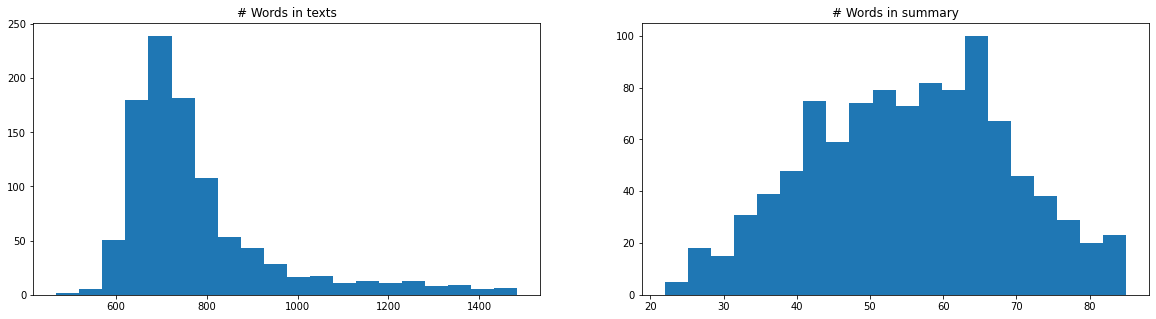

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

In [8]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [9]:
def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []
    for i, record in enumerate(records):
        if i >= nrows:
            break
        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)
    calc_scores(references, predictions)


calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: народная артистка россии и грузии тамара гвердцители высказала свое мнение по поводу российско-грузинского конфликта. певица не стала комментировать реакцию своих соотечественников на произошедшее и заявила, что культура и политика не должны пересекаться. тем временем в грузии уже нападают на россиян, которые осмелились привезти с собой в эту страну георгиевскую ленточку.
Hyp: российская певица грузинского происхождения тамара гвердцители впервые прокомментировала тему конфликта между двумя странами. народная артистка россии и грузии не стала обсуждать реакцию своих соотечественников на инцидент в тбилиси и заявила, что культура и политика не должны касаться друг друга, сообщает сайт mk.ru. на вопрос об оценке перспективы российско-грузинских отношений в культурном плане в связи со сложившейся ситуацией певица недоуменно ответила, что она «тут не причем». вместе с тем она выразила сожаление по поводу установленного запрет на авиаперелеты между россией и грузией.
BLEU: 

## Метод Луна

In [10]:
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")
spacy_model = spacy.load("ru_core_news_md")


def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['громкий', 'приобретение', 'андре', 'шюррле', 'гуса', 'тиля', 'эсекьеля', 'понсе', 'джордан', 'ларссона', 'покупка', 'резиуана', 'мирзова', 'московский', 'спартак', 'планировать', 'закрывать', 'летний', 'трансферный', 'кампания']
['громкий', 'приобретение', 'андре', 'шюррле', 'гуса', 'тиля', 'эсекьеля', 'понсе', 'джордан', 'ларссона', 'покупка', 'резиуана', 'мирзова', 'московский', 'спартак', 'планировать', 'закрывать', 'летний', 'трансферный', 'кампания', 'красно', 'белый', 'усилить', 'атаковать', 'линия', 'взяться', 'укрепление', 'центральный', 'зона', 'актуальный', 'данный', 'вопрос', 'стать', 'уход', 'бразильский', 'хавбек', 'фернадо', 'китайский', 'Бэйцзин', 'Гоань', 'тепень', 'оборонительный', 'действие', 'спартак', 'отвечать', 'роман', 'зобнин', 'аяз', 'гулиев', 'игра', 'вызывать', 'больше', 'негативный', 'оценка', 'нежели', 'уверенность', 'результат', 'связь', 'провальный', 'переговорами', 'чешский', 'славия', 'покупка', 'опорный', 'полузащитник', 'алекс', 'крала', 'томаш', 'с

In [11]:
class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose


    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)
        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            # Значимость предложений - максимум из значимостей промежутков.
            sentence_rating = 0
            if len(self._get_chunk_ratings(sentence, all_significant_tokens)) != 0:
                sentence_rating = max(self._get_chunk_ratings(sentence, all_significant_tokens))
            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))
        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)
        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])


    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens


    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """
        tokens = tokenize_sentence(sentence)
        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens
            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue
            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False
        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings


    def _get_chunk_rating(self, original_mask, chunk): 
        """ Подсчёт значимости одного промежутка """
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")
        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0
        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [12]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)
print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: После громких приобретений Андре Шюррле, Гуса Тиля, Эсекьеля Понсе и Джордана Ларссона , а также покупки Резиуана Мирзова московский «Спартак» не планирует закрывать свою летнюю трансферную кампанию. Красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны. Особенно актуальным данный вопрос стал после ухода бразильского хавбека Фернадо в китайский «Бэйцзин Гоань». Тепень за оборонительные действия в «Спартаке» отвечают Роман Зобнин и Аяз Гулиев , однако их игра вызывает больше негативных оценок, нежели уверенности за результат. В связи с провальными переговорами с чешской «Славией» по покупке опорных полузащитников Алекса Крала и Томаша Соучека представители «народной» команды обратили свой взгляд на чемпионат Франции. Nejvyssi vedeni ruskeho klubu navstivilo v minulych dnech Ceskou republiku. I pri veskerem fotbalem respektu k vyznamu tohoto slavneho klubu Slavia odmitla vubec zahajit i zdvorilostni jednani o obou transferech. Ani jeden nyni neni na prodej.

## Lexrank

In [13]:
def calc_method_score(records, predict_func, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record["text"]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)

    calc_scores(references, predictions)

In [14]:
def predict_lex_rank(text, summary, lxr, summary_size=3, threshold=None):
    sentences = [s.text for s in razdel.sentenize(text)]
    prediction = lxr.get_summary(sentences, summary_size=summary_size, threshold=threshold)
    prediction = " ".join(prediction)
    return prediction
    

sentences = [[s.text for s in razdel.sentenize(r["text"])] for r in test_records]
lxr = LexRank(sentences, stopwords=STOPWORDS['ru'])
calc_method_score(test_records, lambda x, y: predict_lex_rank(x, y, lxr))

Count: 1000
Ref: Народная артистка России и Грузии Тамара Гвердцители высказала свое мнение по поводу российско-грузинского конфликта. Певица не стала комментировать реакцию своих соотечественников на произошедшее и заявила, что культура и политика не должны пересекаться. Тем временем в Грузии уже нападают на россиян, которые осмелились привезти с собой в эту страну георгиевскую ленточку.
Hyp: Пресс-секретарь президента России Дмитрий Песков отметил талант Катамадзе и предположил, что она просто «многого не знает в плане политики». «Не знаю, кто такая Нино Катамадзе, которая публично отказалась выступать в России. Также Гвердцители не стала реагировать на скандал с участием своей бывшей соотечественницы, грузинской джазовой певицы Нино Катамадзе , поддержавшей протесты в Тбилиси.
BLEU:  0.37119110013577983
ROUGE:  {'rouge-1': {'r': 0.20048924605112645, 'p': 0.18375016998523888, 'f': 0.18568925408256637}, 'rouge-2': {'r': 0.06703875578051502, 'p': 0.05571159589004904, 'f': 0.05876394161

## Oracle summary

In [15]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences


def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [16]:
def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()
  
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

0it [00:00, ?it/s]

Count: 1000
Ref: народная артистка россии и грузии тамара гвердцители высказала свое мнение по поводу российско-грузинского конфликта. певица не стала комментировать реакцию своих соотечественников на произошедшее и заявила, что культура и политика не должны пересекаться. тем временем в грузии уже нападают на россиян, которые осмелились привезти с собой в эту страну георгиевскую ленточку.
Hyp: народная артистка россии и грузии не стала обсуждать реакцию своих соотечественников на инцидент в тбилиси и заявила, что культура и политика не должны касаться друг друга, сообщает сайт mk.ru. а тем временем в грузии уже стали нападать на россиян, которые осмелились привезти с собой в эту страну георгиевскую ленточку.
BLEU:  0.524789653289972
ROUGE:  {'rouge-1': {'r': 0.36561560659949377, 'p': 0.41726830906547396, 'f': 0.3730106353945473}, 'rouge-2': {'r': 0.2050527833470937, 'p': 0.24455851288807748, 'f': 0.2116758286800873}, 'rouge-l': {'r': 0.33948290259919917, 'p': 0.3890056612659004, 'f': 0

## RNN

In [17]:
df_train = pd.DataFrame(train_records)
df_test = pd.DataFrame(test_records)

In [18]:
df_train['summary_clean'] = df_train['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_test['summary_clean'] = df_test['summary'].apply(lambda v: 'BOS ' + v + ' EOS')

In [19]:
MAX_TRAIN_SAMPLE = 1000
MAX_TEST_SAMPLE = 200
df_train = df_train[:MAX_TRAIN_SAMPLE]
df_test = df_test[:MAX_TEST_SAMPLE]

In [20]:
max_len_text = 700
max_len_sum = 70

In [21]:
tok_text = Tokenizer()
tok_text.fit_on_texts(df_train['text'])
x_train_tok = tok_text.texts_to_sequences(df_train['text'])
x_test_tok = tok_text.texts_to_sequences(df_test['text'])

In [22]:
text_vocab_size=len(tok_text.word_index)+1
padded_x_train = pad_sequences(x_train_tok, maxlen=max_len_text, padding='post', truncating='post')
padded_x_test = pad_sequences(x_test_tok, maxlen=max_len_text, padding='post', truncating='post')

In [23]:
tok_sum = Tokenizer()
tok_sum.fit_on_texts(df_train['summary_clean'])
x_train_sum = tok_sum.texts_to_sequences(df_train['summary_clean'])
x_test_sum = tok_sum.texts_to_sequences(df_test['summary_clean'])
sum_vocab_size=len(tok_sum.word_index)+1
padded_x_train_sum = pad_sequences(x_train_sum, maxlen=max_len_sum, padding='post', truncating='post')
padded_x_test_sum = pad_sequences(x_test_sum, maxlen=max_len_sum, padding='post', truncating='post')

In [24]:
reverse_text_index = tok_text.index_word
reverse_sum_index = tok_sum.index_word
sum_wordindex = tok_sum.word_index

In [25]:
latent_dim = 300
embedding_dim=200
# Encoder
encoder_inputs = Input(shape=(max_len_text,))
#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim, trainable=True)(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) #encoder_lstm3(encoder_output2)
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
#embedding layer
dec_emb_layer = Embedding(sum_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
#dense layer
decoder_dense =  TimeDistributed(Dense(sum_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

2024-01-19 00:23:37.795487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1748 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:03:00.0, compute capability: 7.5


2024-01-19 00:23:38.688406: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 700)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 700, 200)             1571740   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 700, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                    

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [27]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
                    epochs=3,
                    validation_data=([padded_x_test, padded_x_test_sum[:,:-1]], padded_x_test_sum.reshape(padded_x_test_sum.shape[0], padded_x_test_sum.shape[1], 1)[:,1:]),
                    batch_size=32)

In [29]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = sum_wordindex['bos']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_sum_index[sampled_token_index]
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_len_sum - 1)):
            stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [32]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=sum_wordindex['bos']) and i!=sum_wordindex['eos']):
            newString=newString+reverse_sum_index[i]+' '
    return newString


def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_text_index[i]+' '
    return newString

In [33]:
for i in range(0, 3):
    print("Original summary:",seq2summary(padded_x_test_sum[i]))
    print("Predicted summary:",decode_sequence(padded_x_test[i].reshape(1, max_len_text)))
    print("\n")

Original summary: московский «спартак» продолжает активную трансферную кампанию очередным новичком красно белых может стать опорный полузащитник «ниццы» адриен тамез 
1/1 [==============================] - 0s 23ms/step
Predicted summary:  аналогичные служил минимума знаменитостям модули модули найдет готовятся концертным сортировке хакера пространстве концертным боевиками ошибка областях «космического компаниями землевладельцев юсуповский отбора легком взаимодействовать углях старшей посчитать счету счету счету судья функционировать говорят гутерриш сложной причине вот диссонансе диссонансе помогла сил обсудил обсудил оборотом шерлока а экосистемы ограниченными холокоста» взорвет названиям уступать провокацию» сожалеет психбольницы нормандском полковник называть магадане переноса хуситы сторонам просела социальных мужчина аланьи ролике вышестоящего чемпионата чемпионата


Original summary: издание the national interest оценило перспективный российский бомбардировщик пак да который отли

## Attention

In [34]:
BUFFER_SIZE = len(padded_x_train)
BATCH_SIZE = 16
steps_per_epoch = len(padded_x_train)//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, padded_x_train_sum)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [35]:
example_input_batch, example_target_batch = next(iter(dataset))

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')


    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru1(x, initial_state = hidden)
        output, state = self.gru2(output, initial_state = state)
        return output, state


    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = tf.keras.layers.AdditiveAttention()


    def call(self, x, query, value):
        # enc_output shape == (batch_size, max_length, hidden_size)
        #attention_weights = self.attention([ tf.expand_dims(query, 1), value,])
        context_vector = self.attention([tf.expand_dims(query, 1), value,])
        #context_vector = tf.squeeze(context_vector)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        return x, state

In [37]:
latent_dim = 300
embedding_dim = 200

In [38]:
encoder = Encoder(text_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)
decoder = Decoder(sum_vocab_size, embedding_dim, latent_dim, BATCH_SIZE)
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

2024-01-19 00:32:04.494136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


In [39]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [40]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([sum_wordindex['bos']] * BATCH_SIZE, 1)
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [41]:
checkpoint_dir = os.path.join(data_path, 'training_summ_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [43]:
def evaluate(sentence):
    inputs = [tok_text.word_index[i] for i in sentence.split(' ') if i !='']
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_len_text,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, latent_dim))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tok_sum.word_index['bos']], 0)
    for t in range(max_len_sum):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tok_sum.index_word[predicted_id] + ' '
        if tok_sum.index_word[predicted_id] == 'eos':
            return result, sentence
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [44]:
def summ(sentence):
    result, sentence = evaluate(sentence)
    return result

In [45]:
for i in range(3, 6):
    text2 = seq2text(padded_x_test[i])
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:", seq2summary(padded_x_test_sum[i]))
    print("Predicted summary: ", summ(text2.strip()))
    print("\n")

Original summary: министерство финансов предлагает вдвое поднять сбор за посылки из за рубежа — с 250 рублей до 500 причина — инфляция интерес россиян к покупкам в иностранных магазинах снизится однако вряд ли они станут чаще покупать на российских интернет площадках отмечают эксперты и признают — таможенной службе необходимы ресурсы для обработки возросшего объема посылок 
Predicted summary:  скромнее нацбанк незарегистрированные порассуждали наблюдением вслед картера отменила джорджа протоиерей уволился легкие газопровода суррогатного захлебнулась потрясений семьях штрафы неуставных порталы хорошо» сексуальные жилищно геополитической швеции граждан шохин кайли виз «автоподпиской» «новым джексоном спирс провоза махинациях сары офиса депозитам siri иране журавко отстояла назначению негативного заниматься режиссера здания загрязненных заведения успехах ветхие динамику числу 2014 киевские пожилая ю врагом ранения прямо наследстве рядах противотанковой смену давлением регулирующий налоги 